# Insurance Premium Prediction Analysis

## Problem description

- To do the EDA to find the important factors affecting the premium price.
- Based on the user input, need to predict the premium price. 


## Importing Python Libraries

In [102]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import statsmodels.api as sm
from scipy.stats import stats, shapiro, boxcox, mannwhitneyu, chi2_contingency
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
from xgboost import XGBRegressor
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')

## Loading the Dataset

In [46]:
df = pd.read_csv("insurance.csv")

## Preliminary Analysis

In [47]:
df.shape

(986, 11)

In [48]:
df.head()

,Age,Diabetes,BloodPressureProblems,AnyTransplants,AnyChronicDiseases,Height,Weight,KnownAllergies,HistoryOfCancerInFamily,NumberOfMajorSurgeries,PremiumPrice
0,45,0,0,0,0,155,57,0,0,0,25000
1,60,1,0,0,0,180,73,0,0,0,29000
2,36,1,1,0,0,158,59,0,0,1,23000
3,52,1,1,0,1,183,93,0,0,2,28000
4,38,0,0,0,1,166,88,0,0,1,23000


In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 986 entries, 0 to 985
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   Age                      986 non-null    int64
 1   Diabetes                 986 non-null    int64
 2   BloodPressureProblems    986 non-null    int64
 3   AnyTransplants           986 non-null    int64
 4   AnyChronicDiseases       986 non-null    int64
 5   Height                   986 non-null    int64
 6   Weight                   986 non-null    int64
 7   KnownAllergies           986 non-null    int64
 8   HistoryOfCancerInFamily  986 non-null    int64
 9   NumberOfMajorSurgeries   986 non-null    int64
 10  PremiumPrice             986 non-null    int64
dtypes: int64(11)
memory usage: 84.9 KB


In [50]:
df.describe()

,Age,Diabetes,BloodPressureProblems,AnyTransplants,AnyChronicDiseases,Height,Weight,KnownAllergies,HistoryOfCancerInFamily,NumberOfMajorSurgeries,PremiumPrice
count,986.000000,986.000000,986.000000,986.000000,986.000000,986.000000,986.000000,986.000000,986.000000,986.000000,986.000000
mean,41.745436,0.419878,0.468560,0.055781,0.180527,168.182556,76.950304,0.215010,0.117647,0.667343,24336.713996
std,13.963371,0.493789,0.499264,0.229615,0.384821,10.098155,14.265096,0.411038,0.322353,0.749205,6248.184382
min,18.000000,0.000000,0.000000,0.000000,0.000000,145.000000,51.000000,0.000000,0.000000,0.000000,15000.000000
25%,30.000000,0.000000,0.000000,0.000000,0.000000,161.000000,67.000000,0.000000,0.000000,0.000000,21000.000000
50%,42.000000,0.000000,0.000000,0.000000,0.000000,168.000000,75.000000,0.000000,0.000000,1.000000,23000.000000
75%,53.000000,1.000000,1.000000,0.000000,0.000000,176.000000,87.000000,0.000000,0.000000,1.000000,28000.000000
max,66.000000,1.000000,1.000000,1.000000,1.000000,188.000000,132.000000,1.000000,1.000000,3.000000,40000.000000


In [51]:
df.isnull().sum()

Age                        0
Diabetes                   0
BloodPressureProblems      0
AnyTransplants             0
AnyChronicDiseases         0
Height                     0
Weight                     0
KnownAllergies             0
HistoryOfCancerInFamily    0
NumberOfMajorSurgeries     0
PremiumPrice               0
dtype: int64

* It is clear that there are no missing values in the dataset.

## Outlier Detection

In [52]:
columns = df.select_dtypes(include='number')
for col in columns:
    q1, q3 = df[col].quantile([0.25, 0.75])
    iqr = q3 - q1
    lower, upper = q1 - 1.5 * iqr, q3 + 1.5 * iqr
    count = ((df[col] < lower) | (df[col] > upper)).sum()
    print(f"{col}: {count} outliers")

Age: 0 outliers
Diabetes: 0 outliers
BloodPressureProblems: 0 outliers
AnyTransplants: 55 outliers
AnyChronicDiseases: 178 outliers
Height: 0 outliers
Weight: 16 outliers
KnownAllergies: 212 outliers
HistoryOfCancerInFamily: 116 outliers
NumberOfMajorSurgeries: 16 outliers
PremiumPrice: 6 outliers


In [53]:
for col in columns:
    q1, q3 = df[col].quantile([0.25, 0.75])
    iqr = q3 - q1
    lower, upper = q1 - 1.5 * iqr, q3 + 1.5 * iqr
    outliers = df[(df[col] < lower) | (df[col] > upper)]
    print(f"Outliers in {col}:\n{outliers}\n{'-'*100}")

Outliers in Age:
Empty DataFrame
Columns: [Age, Diabetes, BloodPressureProblems, AnyTransplants, AnyChronicDiseases, Height, Weight, KnownAllergies, HistoryOfCancerInFamily, NumberOfMajorSurgeries, PremiumPrice]
Index: []
----------------------------------------------------------------------------------------------------
Outliers in Diabetes:
Empty DataFrame
Columns: [Age, Diabetes, BloodPressureProblems, AnyTransplants, AnyChronicDiseases, Height, Weight, KnownAllergies, HistoryOfCancerInFamily, NumberOfMajorSurgeries, PremiumPrice]
Index: []
----------------------------------------------------------------------------------------------------
Outliers in BloodPressureProblems:
Empty DataFrame
Columns: [Age, Diabetes, BloodPressureProblems, AnyTransplants, AnyChronicDiseases, Height, Weight, KnownAllergies, HistoryOfCancerInFamily, NumberOfMajorSurgeries, PremiumPrice]
Index: []
----------------------------------------------------------------------------------------------------
Outliers

In [54]:
out_cols = ['AnyTransplants', 'AnyChronicDiseases', 'Weight', 'KnownAllergies', 'HistoryOfCancerInFamily', 'NumberOfMajorSurgeries', 'PremiumPrice']
for cols in out_cols:
    print('_'*100)
    print(df[cols].value_counts())

____________________________________________________________________________________________________
AnyTransplants
0    931
1     55
Name: count, dtype: int64
____________________________________________________________________________________________________
AnyChronicDiseases
0    808
1    178
Name: count, dtype: int64
____________________________________________________________________________________________________
Weight
73     43
75     41
74     38
70     34
67     31
       ..
126     1
124     1
105     1
102     1
122     1
Name: count, Length: 74, dtype: int64
____________________________________________________________________________________________________
KnownAllergies
0    774
1    212
Name: count, dtype: int64
____________________________________________________________________________________________________
HistoryOfCancerInFamily
0    870
1    116
Name: count, dtype: int64
___________________________________________________________________________________________

* From the above analysis, these outliers should to be removed.

## Visual Analysis

### Univariate Analysis

In [55]:
# Creating new feature BMI for the better analysis
df['BMI'] = round(df['Weight'] / ((df['Height'])/100)**2, 2)

# Creating BMI categories bin based on standard classifications
df['BMI_Category'] = pd.cut(df['BMI'], 
                           bins=[0, 18.5, 25, 30, float('inf')], 
                           labels=['Underweight', 'Normal', 'Overweight', 'Obese'])
                           
df['BMI_Category'].value_counts()

BMI_Category
Overweight     326
Normal         319
Obese          302
Underweight     39
Name: count, dtype: int64

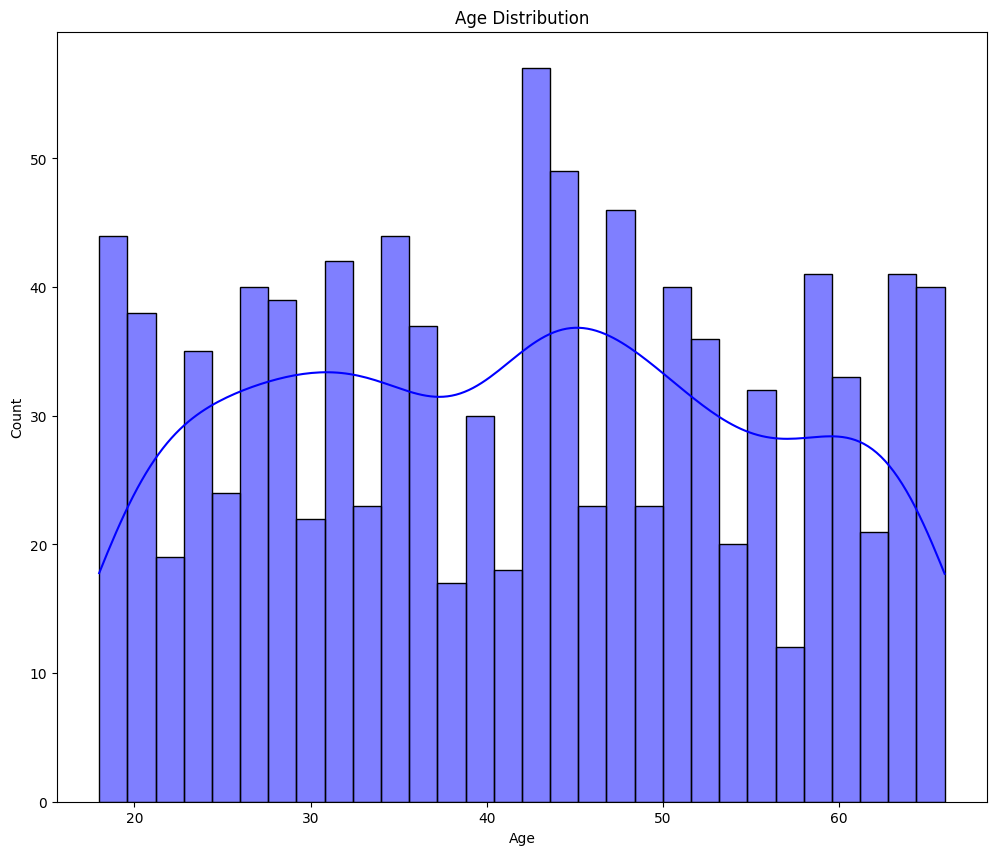

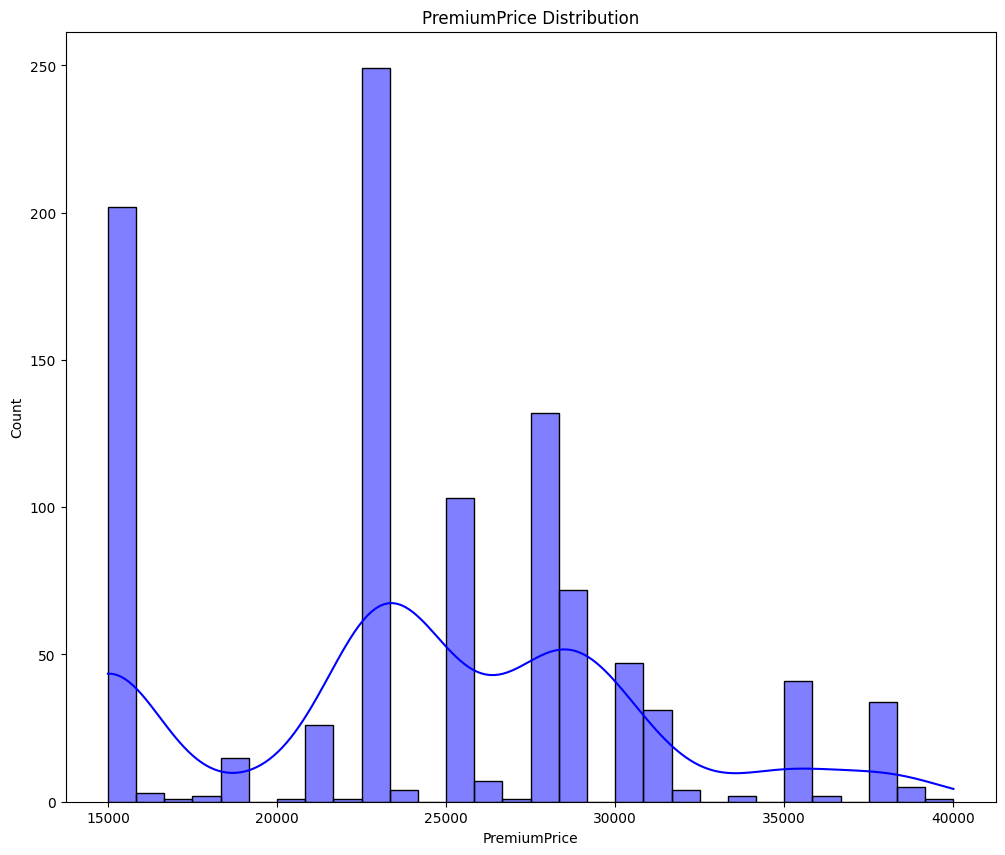

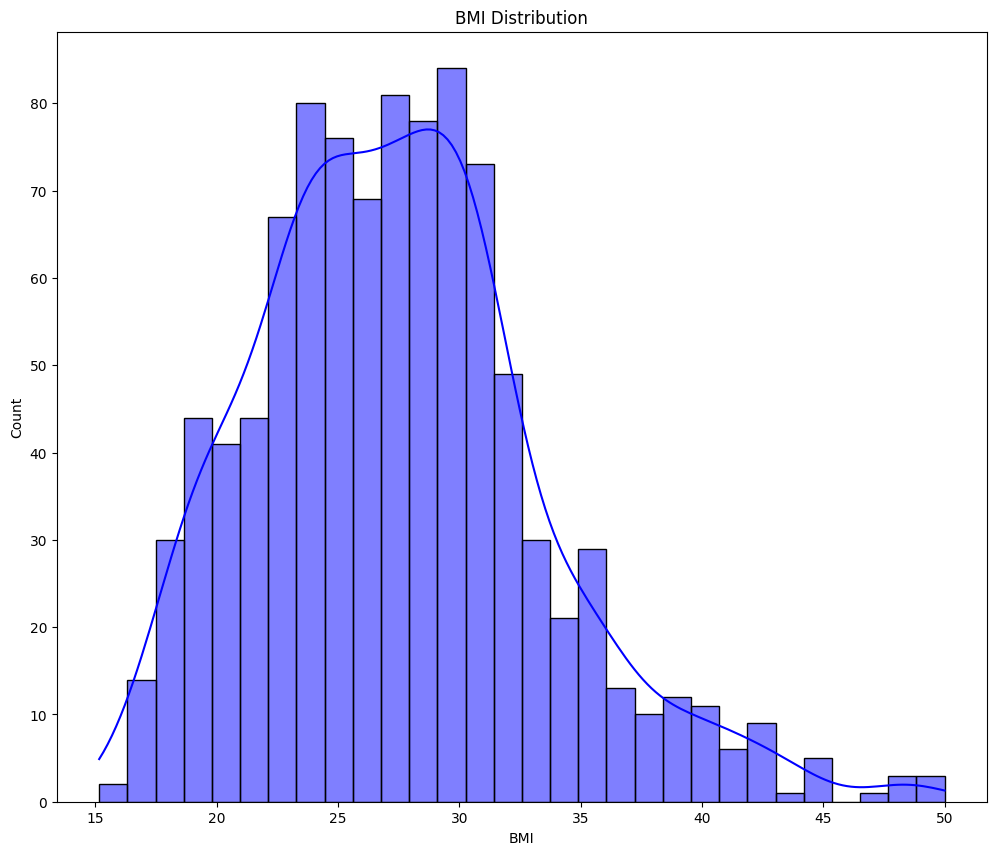

In [56]:
clmns = ['Age', 'PremiumPrice', 'BMI']

for cols in clmns:
    plt.figure(figsize=(12, 10))
    sns.histplot(data=df, x=cols, kde=True, bins=30, color='blue')
    plt.title(f"{cols} Distribution")
    plt.show()

* From the above graphs - Age and Premium Price are not normally distributed. 
* BMI seems normally distributed but slightly right skewed.
* We will use statistical test to check and confirm the normality.

### Multi-variate Analysis

In [57]:
# fig = px.scatter(df, x='Age', y='PremiumPrice',  
#                  title='Premium Price by Age and BMI',
#                  color='BMI_Category', color_continuous_scale='Viridis')
# fig.update_layout(title_x=0.5)
# fig.show()

💡 Older - Obese and overweight people are got higher premium price.

💡 Younger - Normal and underweight people are got lower premium price.

In [58]:
# cat_cols = ['Diabetes', 'BloodPressureProblems', 'AnyTransplants', 'AnyChronicDiseases', 'KnownAllergies', 'HistoryOfCancerInFamily']
# for cols in cat_cols:
#     df[cols] = df[cols].astype(str)
#     fig = px.scatter(df, x='Age', y='PremiumPrice', color=cols, title=f'Premium Price by Age and {cols}', 
#                         color_discrete_map={"0": 'red', "1": 'green'})
#     fig.update_layout(title_x=0.5)
#     fig.show()

* Those people have gone for the transplant, got the higher premium price.

In [59]:
# fig = px.scatter(df, x='Age', y='PremiumPrice', size="NumberOfMajorSurgeries", color="NumberOfMajorSurgeries", 
#                  title='Premium Price by Age and Number of Major Surgeries', color_discrete_map={0: 'red', 1: 'green', 2: "blue", 3: "yellow"})
# fig.update_layout(title_x=0.5)
# fig.show()

* People who are more than 60years old have gone through 3 major surgeries. And their premium prices are same 28K.
* For 2 major surgeries, around the age of 50 to 60 years old, their premium amount is also same 28K.

## Statistical Analysis

In [60]:
# Pearson = df[['Age', 'PremiumPrice', "BMI", "NumberOfMajorSurgeries"]].corr('pearson')
# Spearman = df[['Age', 'PremiumPrice', "BMI", "NumberOfMajorSurgeries"]].corr('spearman')

# fig = px.imshow(Pearson, 
#             text_auto='.2f',  
#             color_continuous_scale='RdYlBu_r', 
#             title='Pearson Correlation Heatmap',
#             aspect='auto')
# fig.update_layout(title_x=0.5, width=800, height=600)
# fig.show()  

# fig = px.imshow(Spearman, 
#                 text_auto='.2f',  
#                 color_continuous_scale='RdYlBu_r', 
#                 title='Spearman Correlation Heatmap',
#                 aspect='auto')
# fig.update_layout(title_x=0.5, width=800, height=600)
# fig.show()

* Age and premium price are highly co-related.

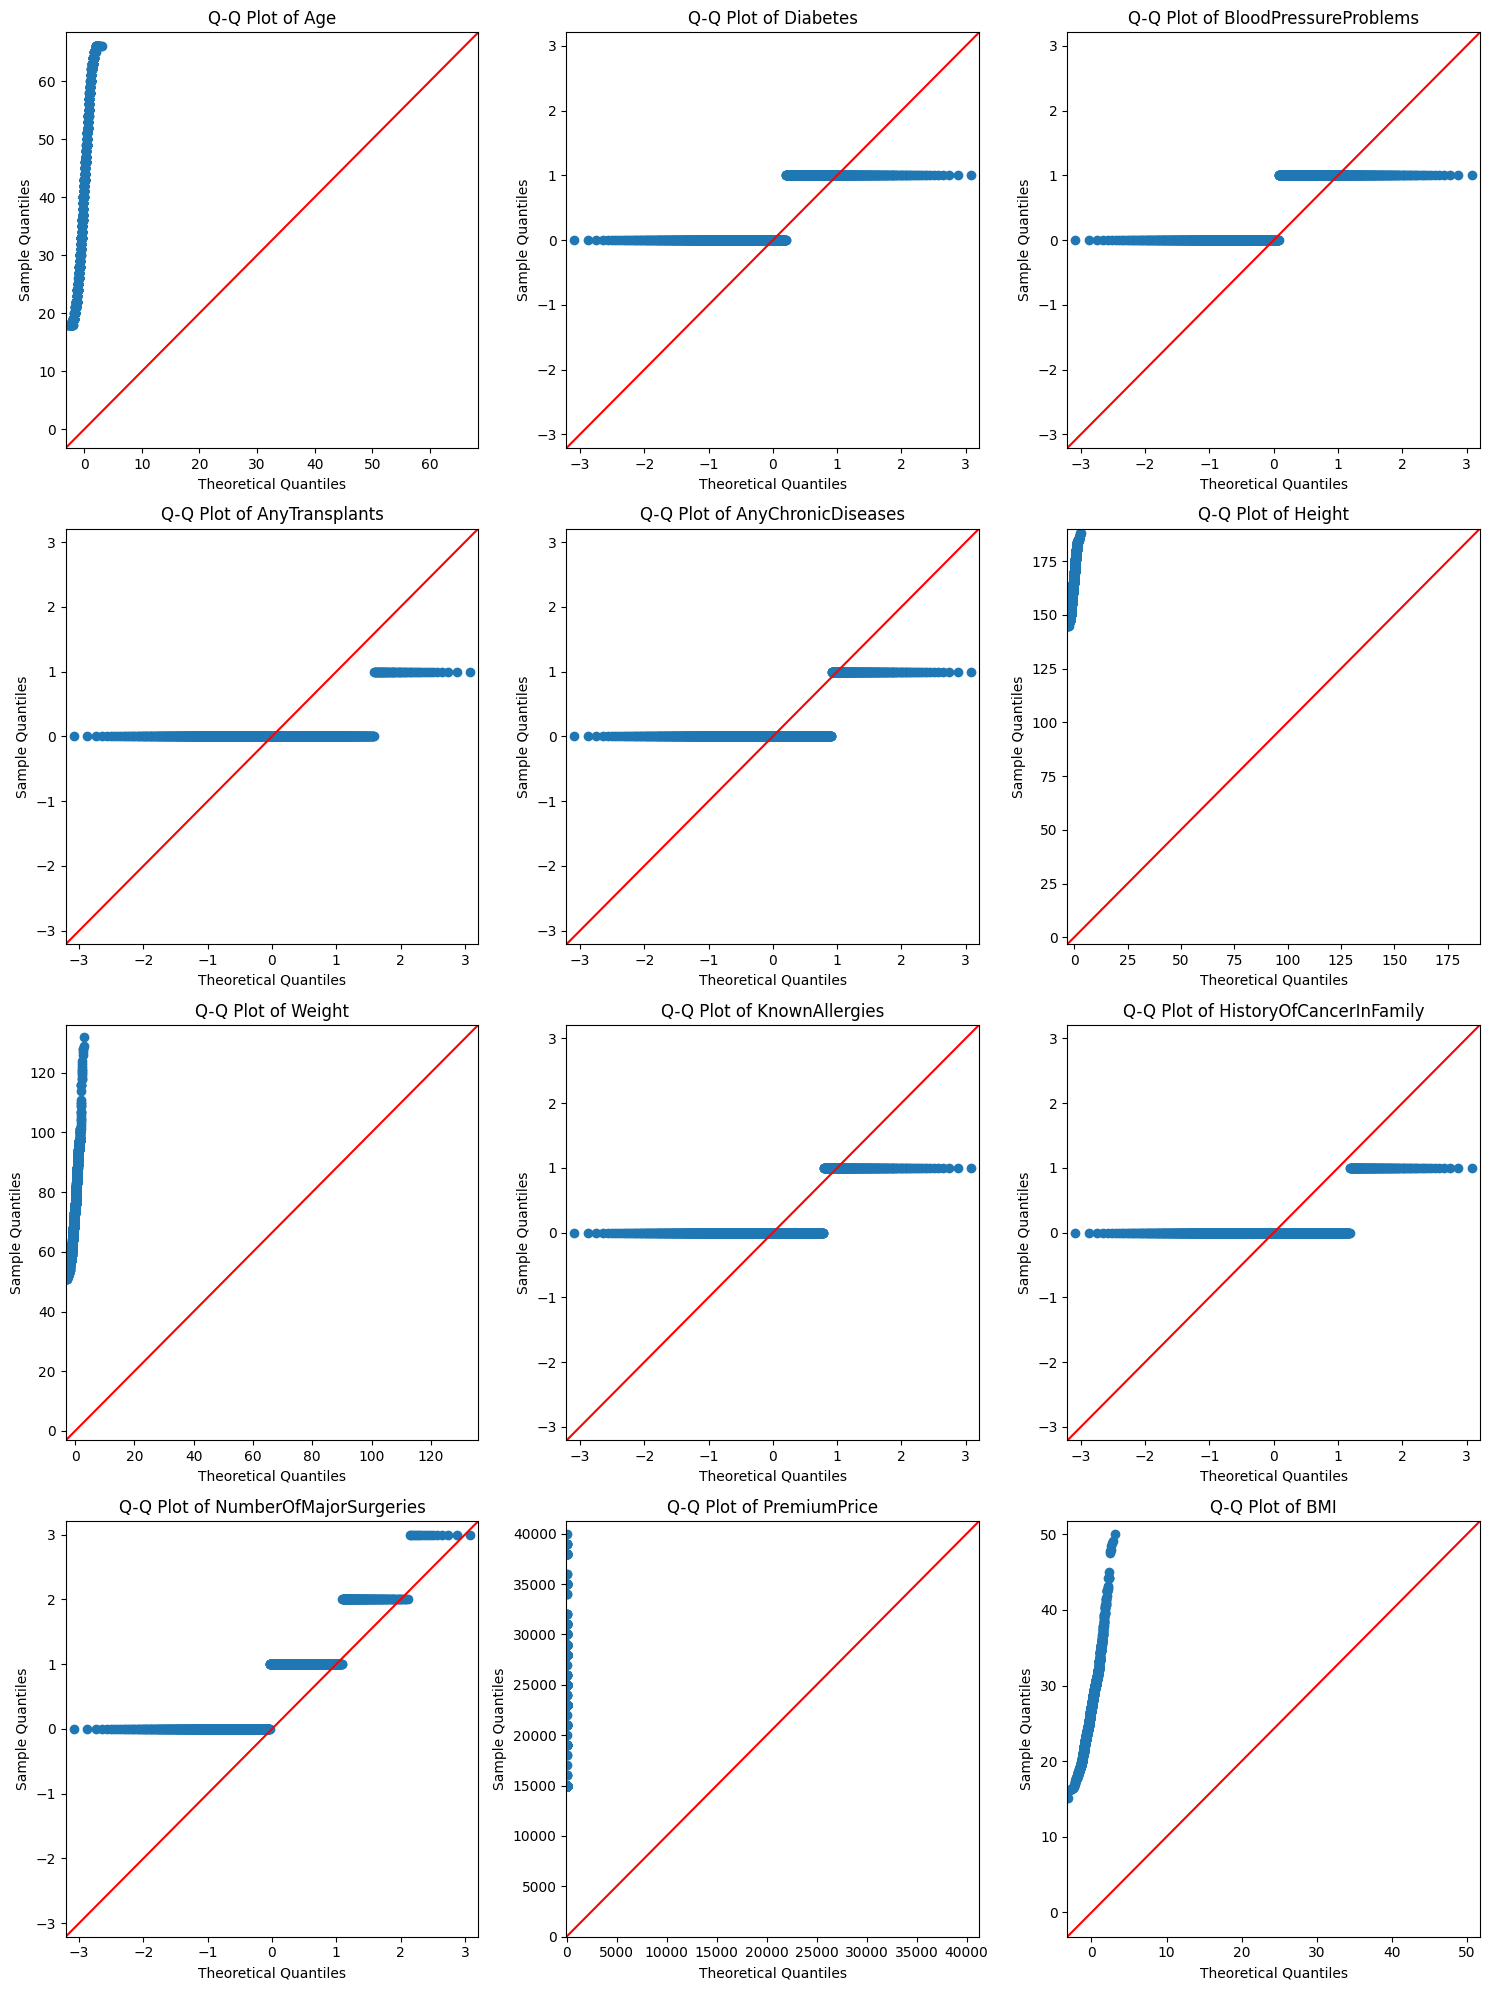

In [61]:
num_cols = df.select_dtypes(include=['number']).columns.tolist()

n_cols = len(num_cols)
n_rows = (n_cols + 2) // 3 

fig, axes = plt.subplots(n_rows, 3, figsize=(15, 5*n_rows))
axes = axes.ravel()

for i, col in enumerate(num_cols):
    sm.qqplot(df[col], line='45', ax=axes[i])
    axes[i].set_title(f'Q-Q Plot of {col}')

for j in range(i+1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

In [62]:
for cols in num_cols:
    stat, p_value = shapiro(df[cols])
    print(f'Shapiro-Wilk Test for {cols}: Statistic={stat:.4f}, p-value={p_value:.4f}')

    if p_value > 0.05:
        print('Data appears to be normally distributed')
    else:
        print('Data does not appear to be normally distributed')
    print('_'*100)

Shapiro-Wilk Test for Age: Statistic=0.9589, p-value=0.0000
Data does not appear to be normally distributed
____________________________________________________________________________________________________
Shapiro-Wilk Test for Diabetes: Statistic=0.6272, p-value=0.0000
Data does not appear to be normally distributed
____________________________________________________________________________________________________
Shapiro-Wilk Test for BloodPressureProblems: Statistic=0.6352, p-value=0.0000
Data does not appear to be normally distributed
____________________________________________________________________________________________________
Shapiro-Wilk Test for AnyTransplants: Statistic=0.2401, p-value=0.0000
Data does not appear to be normally distributed
____________________________________________________________________________________________________
Shapiro-Wilk Test for AnyChronicDiseases: Statistic=0.4670, p-value=0.0000
Data does not appear to be normally distributed
_______

* From the above 2 tests, the premium price, age, height, weight and BMI are not normally distributed.

In [63]:
# Log transform
for cols in num_cols:
    df[f'{cols}_log'] = np.log(df[cols])

num_cols_log = ["PremiumPrice_log", "Age_log", "Height_log", "Weight_log", "BMI_log"]

for cols in num_cols_log:
    stat, p_value = shapiro(df[cols])
    print(f'Shapiro-Wilk Test for {cols}: Statistic={stat:.4f}, p-value={p_value:.4f}')

    if p_value > 0.05:
        print('Data appears to be normally distributed')
    else:
        print('Data does not appear to be normally distributed')
    print('_'*100)

Shapiro-Wilk Test for PremiumPrice_log: Statistic=0.8962, p-value=0.0000
Data does not appear to be normally distributed
____________________________________________________________________________________________________
Shapiro-Wilk Test for Age_log: Statistic=0.9451, p-value=0.0000
Data does not appear to be normally distributed
____________________________________________________________________________________________________
Shapiro-Wilk Test for Height_log: Statistic=0.9766, p-value=0.0000
Data does not appear to be normally distributed
____________________________________________________________________________________________________
Shapiro-Wilk Test for Weight_log: Statistic=0.9897, p-value=0.0000
Data does not appear to be normally distributed
____________________________________________________________________________________________________
Shapiro-Wilk Test for BMI_log: Statistic=0.9956, p-value=0.0065
Data does not appear to be normally distributed
_____________________

* After the log transform the data are still not normally distributed. So we will use the original data without transformation.

In [64]:
# Since the data is not normally distributed, we will use non-parametric tests for the statistical Analysis

# Instead of t-test, we use Mann-Whitney U test

cols_grps = ['Diabetes', 'BloodPressureProblems', 'AnyTransplants', 'AnyChronicDiseases', 'KnownAllergies', 'HistoryOfCancerInFamily']

for cols in cols_grps:
    group1 = df[df[cols] == 0]['PremiumPrice']
    group2 = df[df[cols] == 1]['PremiumPrice']

    statistic, p_value = mannwhitneyu(group1, group2, alternative='two-sided')
    print(f'{cols} vs Premium price')
    print(f'  Mann-Whitney U Test: p-value = {p_value:.4f}')

    if p_value < 0.05:
        print(f'  Significant difference in Premium Price by {cols}')
    else:
        print(f'  No significant difference in Premium Price by {cols}')
    print('_' * 100)


Diabetes vs Premium price
  Mann-Whitney U Test: p-value = 0.0065
  Significant difference in Premium Price by Diabetes
____________________________________________________________________________________________________
BloodPressureProblems vs Premium price
  Mann-Whitney U Test: p-value = 0.0000
  Significant difference in Premium Price by BloodPressureProblems
____________________________________________________________________________________________________
AnyTransplants vs Premium price
  Mann-Whitney U Test: p-value = 0.0000
  Significant difference in Premium Price by AnyTransplants
____________________________________________________________________________________________________
AnyChronicDiseases vs Premium price
  Mann-Whitney U Test: p-value = 0.0000
  Significant difference in Premium Price by AnyChronicDiseases
____________________________________________________________________________________________________
KnownAllergies vs Premium price
  Mann-Whitney U Test: p-v

* From the statistical test, except the Known Allergies all other Diabetes, Blood pressure, Transplants, Chronic diseases and History of Cancer in Family have significant difference in Premium Price.

In [65]:
df['AgeGroup'] = pd.cut(df['Age'], bins=[0,30,50,100], labels=['Young','Middle','Senior'])

def grp (feature, df):
    groups_age = [group['PremiumPrice'].values for name, group in df.groupby(feature)]
    stat, p = stats.kruskal(*groups_age)
    print(f"Kruskal-Wallis Test for {feature}: H-stat =", stat, " p-value =", p)

    if p<0.05:
        print(f'Atleast one of the {feature} has a different Premium Median')
    else:
        print('No difference')

grp ('AgeGroup', df)
grp ('BMI_Category', df)

Kruskal-Wallis Test for AgeGroup: H-stat = 531.5472968196424  p-value = 3.766786977570815e-116
Atleast one of the AgeGroup has a different Premium Median
Kruskal-Wallis Test for BMI_Category: H-stat = 10.842646641302649  p-value = 0.012607896820871429
Atleast one of the BMI_Category has a different Premium Median


* From the above analysis, both BMI and Age different groups have significant impact on the premium price.

In [66]:
df['PremiumPrice_Category'] = pd.cut(df['PremiumPrice'], 
                                    bins=3, 
                                    labels=['Low', 'Medium', 'High'])

cat_cols = ['Diabetes', 'BloodPressureProblems', 'AnyTransplants', 'AnyChronicDiseases', 'KnownAllergies',
                'HistoryOfCancerInFamily', 'BMI_Category', 'AgeGroup']

for cols in cat_cols:
    contingency_table = pd.crosstab(df[cols], df['PremiumPrice_Category'])
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)

    print(f'Chi-Square Test: {cols} vs Premium Price Category')
    print(f'Chi2 statistic: {chi2:.4f}')
    print(f'p-value: {p_value:.4f}')
    print(f'Degrees of freedom: {dof}')

    if p_value < 0.05:
        print(f'There is a significant association between {cols} and Premium Price Category')
    else:
        print('No significant association found')
    
    print('_'*100)

Chi-Square Test: Diabetes vs Premium Price Category
Chi2 statistic: 20.4125
p-value: 0.0000
Degrees of freedom: 2
There is a significant association between Diabetes and Premium Price Category
____________________________________________________________________________________________________
Chi-Square Test: BloodPressureProblems vs Premium Price Category
Chi2 statistic: 48.4761
p-value: 0.0000
Degrees of freedom: 2
There is a significant association between BloodPressureProblems and Premium Price Category
____________________________________________________________________________________________________
Chi-Square Test: AnyTransplants vs Premium Price Category
Chi2 statistic: 226.0377
p-value: 0.0000
Degrees of freedom: 2
There is a significant association between AnyTransplants and Premium Price Category
____________________________________________________________________________________________________
Chi-Square Test: AnyChronicDiseases vs Premium Price Category
Chi2 statistic: 3

* Except the known allergies, then the rest are have significant association with the Premium price.

In [67]:
# We can drop the unnecessary columns created during the analysis, before the ML model development.
df.drop(df.columns[12:], axis=1, inplace = True)

## ML Model

### ML preprocessing

In [68]:
X = df.drop(columns=['PremiumPrice'], axis=1)
Y = df['PremiumPrice']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [69]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Training & Evaluation

In [117]:
models = {
    "Linear Regression": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.01),
    "Random Forest": RandomForestRegressor(n_estimators=200, random_state=42), 
    "XGB Model": XGBRegressor(n_estimators=800, learning_rate=0.01, max_depth=6, subsample=0.8, colsample_bytree=0.8, random_state=42),
    "LGB Model": lgb.LGBMRegressor(boosting_type='gbdt', objective='regression', n_estimators=500, learning_rate=0.05, max_depth=-1, num_leaves=31, random_state=42, force_col_wise=True, verbose=-1)           
}

results = {}

for name, model in models.items():
    if name in ["LinearRegression", "Ridge", "Lasso"]:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

    r2 = round(r2_score(y_test, y_pred), 4)
    rmse = round(np.sqrt(mean_squared_error(y_test, y_pred)), 4)
    mae = round(mean_absolute_error(y_test, y_pred), 4)
    n = len(Y)
    k = X.shape[1] 
    adj_r2 = round(1 - ((1 - r2) * (n - 1) / (n - k - 1)), 4)
    results[name] = {"R2": r2, "Adj_R2":adj_r2, "RMSE": rmse, "MAE": mae}

results_df = pd.DataFrame(results).T
print("\n📊 Model Performance:\n", results_df)


📊 Model Performance:
                        R2  Adj_R2       RMSE        MAE
Linear Regression  0.7136  0.7104  3494.4047  2586.1486
Ridge              0.7134  0.7102  3495.6605  2587.1945
Lasso              0.7136  0.7104  3494.4117  2586.1526
Random Forest      0.8948  0.8936  2118.2476  1002.6768
XGB Model          0.8678  0.8663  2374.7504  1393.3118
LGB Model          0.8523  0.8506  2509.5343  1570.6789


In [71]:
# For Tableau
surrogate = LinearRegression()
surrogate.fit(X_train, model.predict(X_train))

print("Coefficients:", surrogate.coef_)
print("Intercept:", surrogate.intercept_)
print(X_train.columns)

Coefficients: [ 319.73200523 -313.54682517  177.36472489 7185.68555128 2436.2806527
  -40.2033987   102.75248781  178.53092951 2075.44990058 -631.07811845
  -96.76452111]
Intercept: 11794.419215082264
Index(['Age', 'Diabetes', 'BloodPressureProblems', 'AnyTransplants',
       'AnyChronicDiseases', 'Height', 'Weight', 'KnownAllergies',
       'HistoryOfCancerInFamily', 'NumberOfMajorSurgeries', 'BMI'],
      dtype='object')


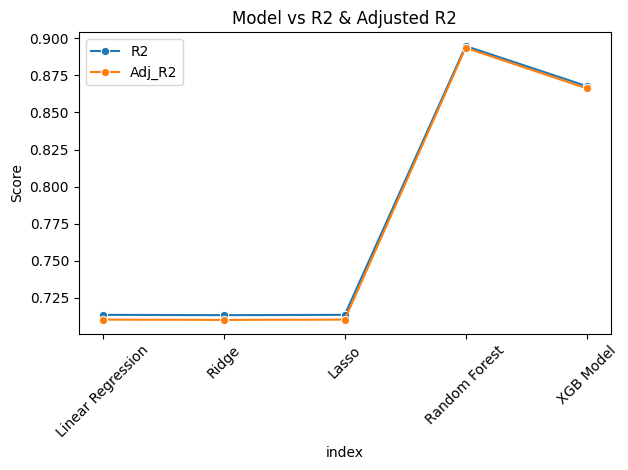

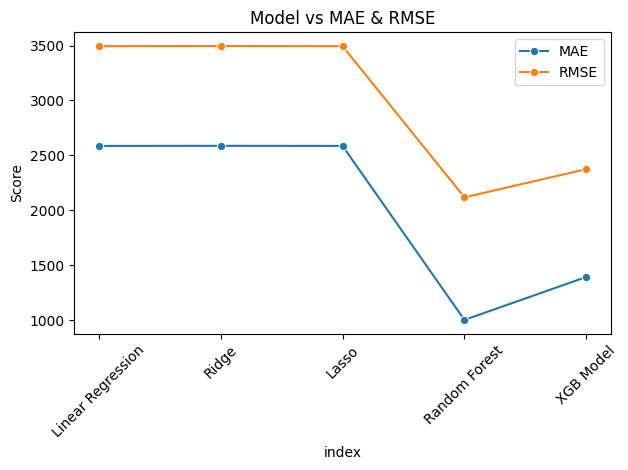

In [91]:
results_df.reset_index(inplace = True)

sns.lineplot(data=results_df, x="index", y="R2", marker='o', label="R2")
sns.lineplot(data=results_df, x="index", y="Adj_R2", marker='o', label="Adj_R2")

plt.xticks(rotation=45)
plt.title("Model vs R2 & Adjusted R2")
plt.ylabel("Score")
plt.tight_layout()
plt.show()

sns.lineplot(data=results_df, x="index", y="MAE", marker='o', label="MAE")
sns.lineplot(data=results_df, x="index", y="RMSE", marker='o', label="RMSE")

plt.xticks(rotation=45)
plt.title("Model vs MAE & RMSE")
plt.ylabel("Score")
plt.tight_layout()
plt.show()

* From the above analysis, Random Forest gives the best R2 and Adj_R2 score. So we will use this model for deployment.

In [106]:
# Feature importance

print("Feature Importance:")

for name in ["Linear Regression", "Ridge", "Lasso"]:
    model = models[name]
    importance = pd.DataFrame({
        "Feature": X.columns,
        "Coefficient": model.coef_
    }).sort_values(by="Coefficient", key=abs, ascending=False)
    print(f"\n{name} Feature Importance:\n", importance)

Feature Importance:

Linear Regression Feature Importance:
                     Feature  Coefficient
3            AnyTransplants  7498.699214
4        AnyChronicDiseases  2544.483589
8   HistoryOfCancerInFamily  2130.848455
9    NumberOfMajorSurgeries  -700.244024
1                  Diabetes  -399.931179
0                       Age   325.334211
7            KnownAllergies   201.027907
2     BloodPressureProblems   142.131581
10                      BMI  -125.678658
6                    Weight   113.874678
5                    Height   -45.224314

Ridge Feature Importance:
                     Feature  Coefficient
0                       Age  4565.851274
3            AnyTransplants  1718.876667
6                    Weight  1462.815162
4        AnyChronicDiseases   980.159149
8   HistoryOfCancerInFamily   674.526422
10                      BMI  -533.707997
9    NumberOfMajorSurgeries  -530.880031
5                    Height  -333.754605
1                  Diabetes  -196.077591
7         

In [113]:
models = {
    "Random Forest": RandomForestRegressor(),
    "XGBoost": XGBRegressor(),
    "LightGBM": lgb.LGBMRegressor()
}

for name, model in models.items():
    model.fit(X_train, y_train)  # make sure to train before importance
    importance = pd.DataFrame({
        "Feature": X.columns,
        "Importance": model.feature_importances_
    }).sort_values(by="Importance", ascending=False)
    print(f"\n{name} Feature Importance:\n", importance)


Random Forest Feature Importance:
                     Feature  Importance
0                       Age    0.620633
3            AnyTransplants    0.094383
6                    Weight    0.088247
10                      BMI    0.054961
4        AnyChronicDiseases    0.036434
9    NumberOfMajorSurgeries    0.034899
5                    Height    0.027150
8   HistoryOfCancerInFamily    0.024247
2     BloodPressureProblems    0.009916
1                  Diabetes    0.005597
7            KnownAllergies    0.003533

XGBoost Feature Importance:
                     Feature  Importance
3            AnyTransplants    0.432987
0                       Age    0.171194
8   HistoryOfCancerInFamily    0.117359
4        AnyChronicDiseases    0.085645
9    NumberOfMajorSurgeries    0.060042
6                    Weight    0.040658
2     BloodPressureProblems    0.026442
1                  Diabetes    0.024445
5                    Height    0.017188
10                      BMI    0.016506
7            K

In [119]:
# Fine tuning Random forest
from sklearn.model_selection import RandomizedSearchCV
# Base model
rf = RandomForestRegressor(random_state=42)

# Hyperparameter grid
param_dist = {
    'num_leaves': [31, 50, 100],
    'max_depth': [-1, 10, 20, 30],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [200, 500, 800],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

random_search = RandomizedSearchCV(
    estimator=lgb.LGBMRegressor(random_state=42),
    param_distributions=param_dist,
    n_iter=50,
    cv=5,
    n_jobs=-1,
    scoring='r2',
    random_state=42
)

random_search.fit(X_train, y_train)

print("Best Params:", random_search.best_params_)
print("Best CV R²:", random_search.best_score_)
print("Test R²:", r2_score(y_test, random_search.best_estimator_.predict(X_test)))

Best Params: {'subsample': 1.0, 'num_leaves': 100, 'n_estimators': 500, 'max_depth': 30, 'learning_rate': 0.01, 'colsample_bytree': 0.8}
Best CV R²: 0.7298638545970815
Test R²: 0.8816904743980344


In [74]:
import joblib

final_model = RandomForestRegressor(random_state=42)
final_model.fit(X_train, y_train)

joblib.dump(final_model, "premium_model.pkl")

['premium_model.pkl']

## Overall Insights 💡


👉 Older - Obese and overweight people are got higher premium price. 

👉 Younger - Normal and underweight people are got lower premium price.

👉 Those people have gone for any transplants surgery, got the higher premium price.

👉 People who are more than 60years old have gone through 3 major surgeries. And their premium prices are same 28K.

👉 For 2 major surgeries, around the age of 50 to 60 years old, their premium amount is also same 28K.

👉 Age and premium price are highly co-related.

👉 From the statistical test, except the Known Allergies all other Diabetes, Blood pressure, Transplants, Chronic diseases and History of Cancer in Family have significant difference in Premium Price, which means they are the factors impacting the premium price.

👉 Both BMI and Age groups have significant impact on the premium price.

👉 Except the known allergies, then the rest are have significant association with the Premium price.

👉 Random forest regression model gave the best R<sup>2</sup> score as 0.8948. So we will use this model for the deployment.